In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [7]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = 1e-22
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}
        self.adsorption = []
        self.desorption = []
        self.diffusion = []

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        des = -self.e_int_des * n_ij + self.e_des
        return ads, des

    def calculate_transition_rates(self, site):
        E_ads, E_des = self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0
        while self.time < end_time:

            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / k_total)/self.factor
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.adsorption.append(self.events_count["adsorption"])
            self.desorption.append(self.events_count["desorption"])
            self.diffusion.append(self.events_count["diffusion"])

            # Store occupancy at specific target times
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100


        return self.occupancy

In [8]:
import pandas as pd

data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)


time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])


FileNotFoundError: [Errno 2] No such file or directory: 'Datos recogidos.csv'

{'adsorption': 109075, 'desorption': 3134, 'diffusion': 4566}
Saturation:  51.10034602076124 %


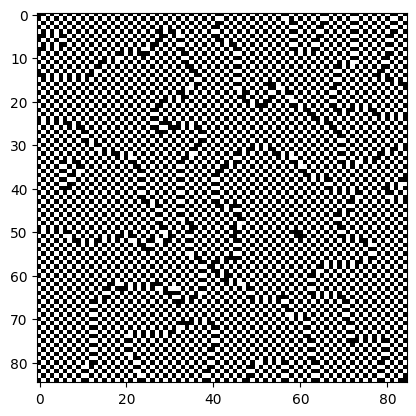

In [9]:
lattice_size = 85
T = 280
e_ads = -1.82
e_des = 1.25
e_diff = -0.579
e_int_abs = 0.608
e_int_des = 0.89
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,time_array=time_array)
occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()


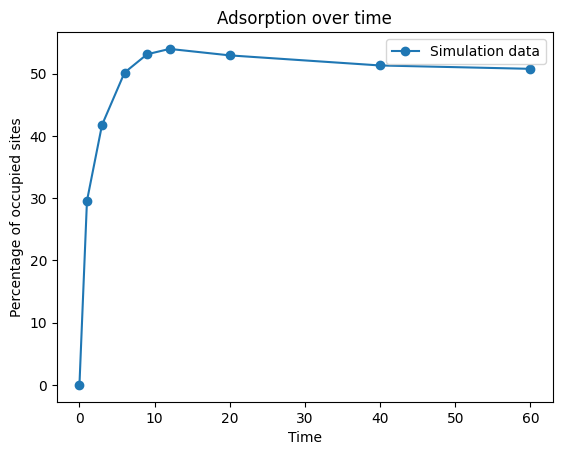

In [5]:
#exp_data = data.iloc[8]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


#plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

#mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
#print(f"Mean Squared Error (MSE): {mse}")

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def objective_function(params, time_points, experimental_data):
    """
    Calcula el MSE entre los datos simulados y experimentales.
    :param params: Lista con los parámetros [Ea, k]
    :param time_points: Puntos de tiempo
    :param experimental_data: Datos experimentales
    :return: Error cuadrático medio (MSE)
    """
    T, e_ads, e_des, e_diff, e_int_abs, e_int_des = params  # Desempaquetamos los parámetros
    kmc = KineticMonteCarlo(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)
    occupancy = kmc.run_simulation()
    simulated_data = np.array(list(occupancy.values()))
    mse = mean_squared_error(experimental_data, simulated_data)
    return mse


class TqdmCallback:
    def __init__(self, total):
        self.pbar = tqdm(total=total)

    def __call__(self, xk):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

In [ ]:
initial_guess = np.array([T, e_ads, e_des, e_diff, e_int_abs, e_int_des])

iterations = 100  # Número estimado de iteraciones

callback = TqdmCallback(total=iterations)

result = minimize(objective_function, initial_guess, args=(time_array, np.array(exp_data)),
                  method='Nelder-Mead', options={'disp': True, 'maxiter': iterations}, callback=callback)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
T, e_ads, e_des, e_diff, e_int_abs, e_int_des = result.x


KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,time_array=time_array)
occupancy = KMC.run_simulation()
KMC.events_count

simulated_data = list(occupancy.values())


plt.scatter(time_array,exp_data, label='Experimental data', color = 'red')
plt.plot(time_array,simulated_data, label='Simulation data', color='black')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")